In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedGroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Importación de tu clase personalizada
from class_imbalance import ImbalanceHandler

# Configuración de reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

El dataset seleccionat té valors ordenats segons el temps, de manera que per predir la clase, pot ser relevant utilitzar dades de instants anteriors, això es referit com a "lag features". A continuació farem un estudi de la correlació entre les features abans de crear les "lag features".  

In [27]:
# Parámetros
NUM_LAGS = 5
COLUMNAS_A_ELIMINAR = ['Num', 'Timestamp'] 

# 1. Carga de datos
df = pd.read_csv('robot_dataset.csv')
df.columns = df.columns.str.strip() # Eliminar espacios en blanco de los nombres de las columnas

# 2. Crear Target Combinado (0 a 3)
# 0: OK | 1: Grip Lost | 2: Protective Stop | 3: Ambos
mapping = {'False': 0, 'True': 1, False: 0, True: 1}
stop = df['Robot_ProtectiveStop'].map(mapping)
grip = df['grip_lost'].map(mapping)
df['Status_Combined'] = (stop * 2) + grip

# 3. Limpieza de columnas innecesarias
df_prep = df.drop(columns=COLUMNAS_A_ELIMINAR + ['Robot_ProtectiveStop', 'grip_lost'], errors='ignore')
df_prep = df_prep.dropna().copy()

groups = df_prep['cycle'].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(df_prep, groups=groups))

# Creamos DataFrames separados. 
df_train = df_prep.iloc[train_idx].copy()
df_test = df_prep.iloc[test_idx].copy()

# 4. Generación dinámica de Lags
sensor_cols = [col for col in df_prep.columns if any(x in col for x in ['Current', 'Temperature', 'Speed', 'Tool_current'])]


In [37]:
df

,Num,Timestamp,Current_J0,Temperature_T0,Current_J1,Temperature_J1,Current_J2,Temperature_J2,Current_J3,Temperature_J3,...,Speed_J1,Speed_J2,Speed_J3,Speed_J4,Speed_J5,Tool_current,cycle,Robot_ProtectiveStop,grip_lost,Status_Combined
0,1,2022-10-26T08:17:21.847Z,0.109628,27.8750,-2.024669,29.3750,-1.531442,29.3750,-0.998570,32.1250,...,-0.000490,0.001310,-0.132836,-0.007479,-0.152962,0.082732,1,False,False,0.0
1,2,2022-10-26T08:17:22.852Z,0.595605,27.8750,-2.278456,29.3125,-0.866556,29.4375,-0.206097,32.1875,...,-0.000304,0.002185,0.001668,-0.000767,0.000417,0.505895,1,False,False,0.0
2,3,2022-10-26T08:17:23.857Z,-0.229474,27.8750,-2.800408,29.3125,-2.304336,29.4375,-0.351499,32.1250,...,0.007795,-2.535874,0.379867,0.000455,-0.496856,0.079420,1,False,False,0.0
3,4,2022-10-26T08:17:24.863Z,0.065053,27.8750,-3.687768,29.3125,-1.217652,29.4375,-1.209115,32.1250,...,-0.004911,-0.009096,-0.384196,0.018411,0.425559,0.083325,1,False,False,0.0
4,5,2022-10-26T08:17:25.877Z,0.884140,27.8750,-2.938830,29.3750,-1.794076,29.4375,-2.356471,32.1875,...,0.005567,0.001138,-0.353284,0.014994,0.180989,0.086379,1,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7404,7405,2022-10-26T15:36:02.555Z,-0.109017,37.1875,-2.261695,40.3125,-1.082678,40.6875,-0.494714,43.3750,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.080013,264,False,False,0.0
7405,7406,2022-10-26T15:36:03.562Z,-0.098536,37.1875,-2.251992,40.3125,-1.094420,40.6875,-0.515789,43.3750,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.078740,264,False,False,0.0
7406,7407,2022-10-26T15:36:04.571Z,-0.121100,37.1875,-2.280791,40.2500,-1.121319,40.6875,-0.502406,43.3750,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.091471,264,False,False,0.0
7407,7408,2022-10-26T15:36:05.572Z,-0.129370,37.1875,-2.269061,40.3125,-1.091610,40.6250,-0.491158,43.3750,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.090026,264,False,False,0.0


## Estudi del dataset

El dataset contiene informacion de 5 joints. Cada joint tiene 3 sensores:
- Corriente (Current)
- Temperatura (Temperature)
- Velociodad (Velocity)

<Figure size 1200x1000 with 0 Axes>

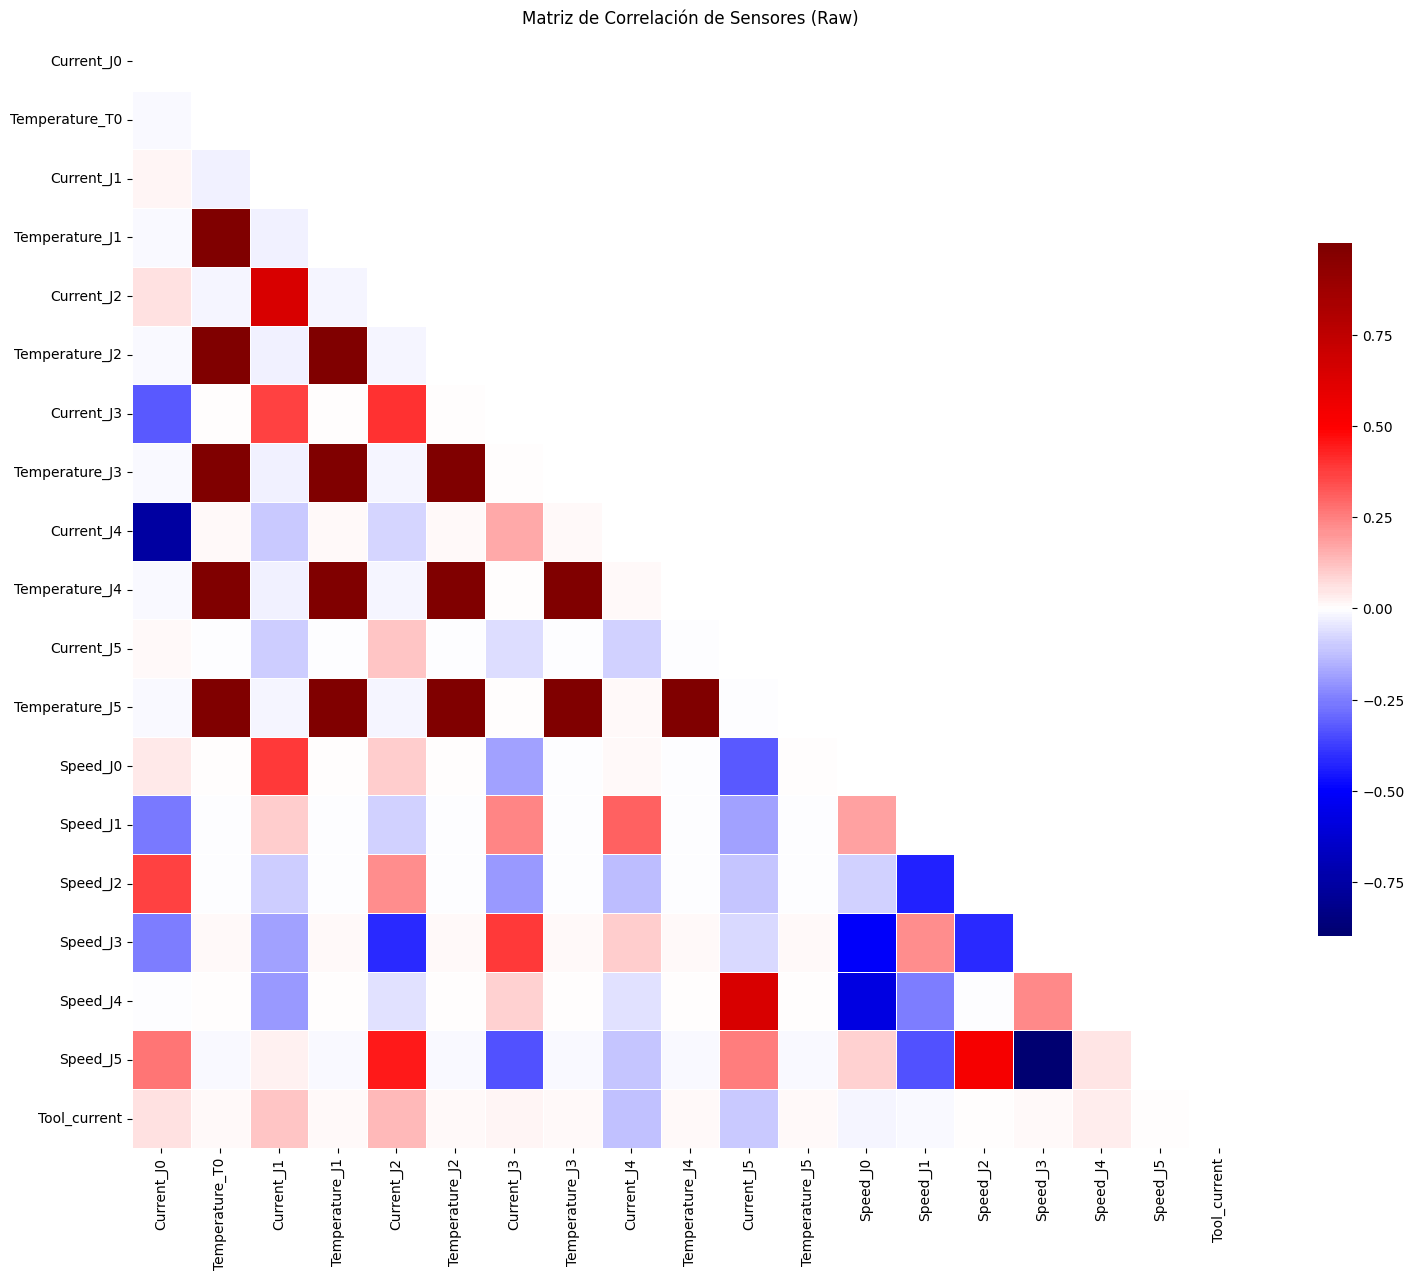

In [44]:

plt.figure(figsize=(12, 10))
corr = df_train[sensor_cols].corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(18, 18))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.title("Matriz de Correlación de Sensores (Raw)")
plt.show()

En el heatmap anterior se puede observar la correlacion entre las distintas variables. Se puede encontrar una alta correlacion entre la temperatura de los distintos sensores, es decir, cuando la temperatura de un sensor aumenta, la de los otros sensores también tiende a aumentar. Exactamente lo msimo ocurre con la corriente y la velocidad, cuando la velocidad de un sensor aumenta, su velocidad también lo hace.

De manera que tenemos variables altamente correlacionadas entre sí, mas adelante haremos un estudio de reducción de dimensionalidad.

## Autocorrelació en el temps de sensors.
Estudio de autocorrelacion en el tiempo para cada sensor. El objetivo es determinar el número adecuado de lags a utilizar en la creación de features de **lag**.

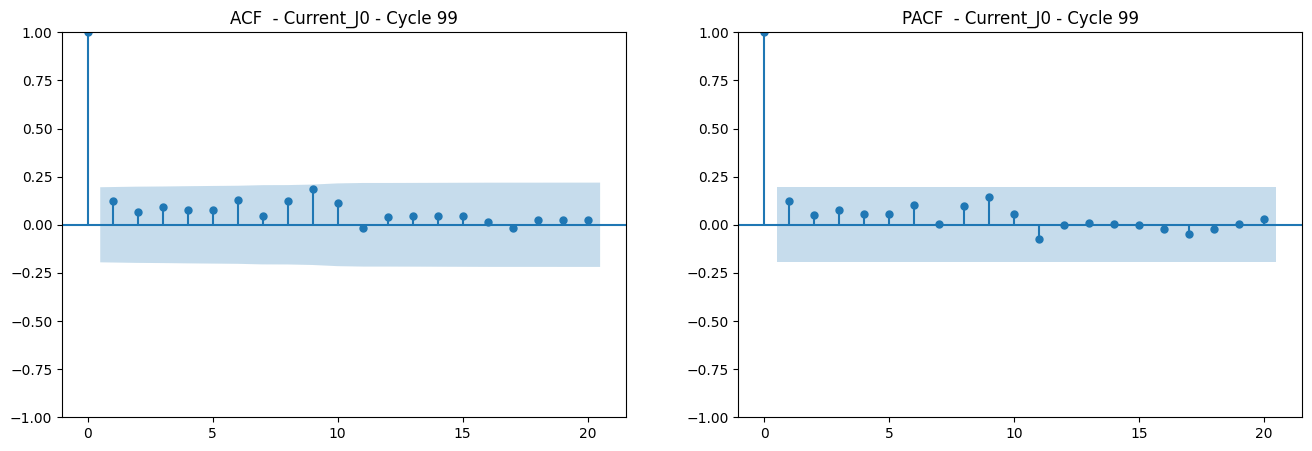

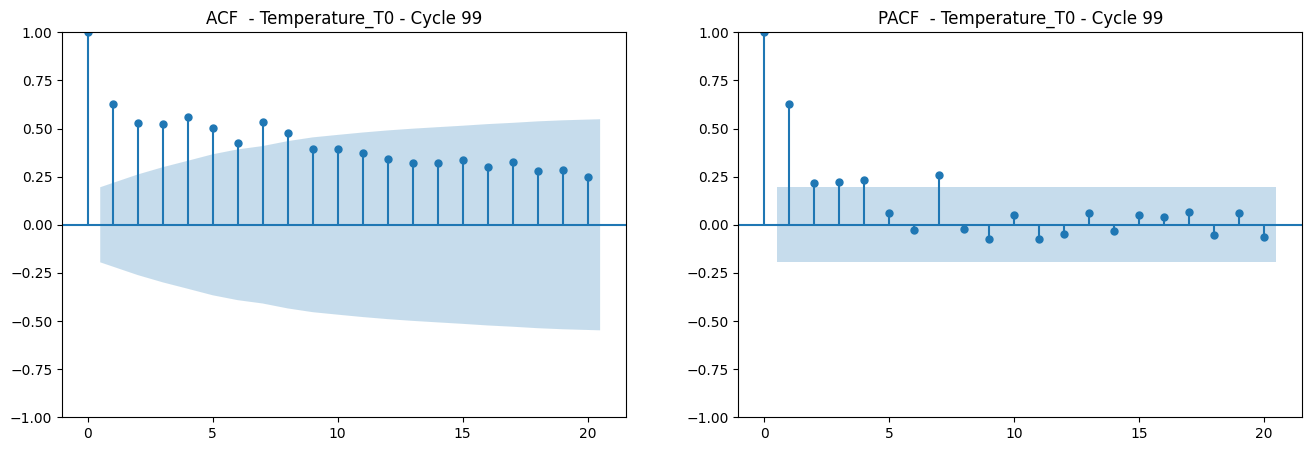

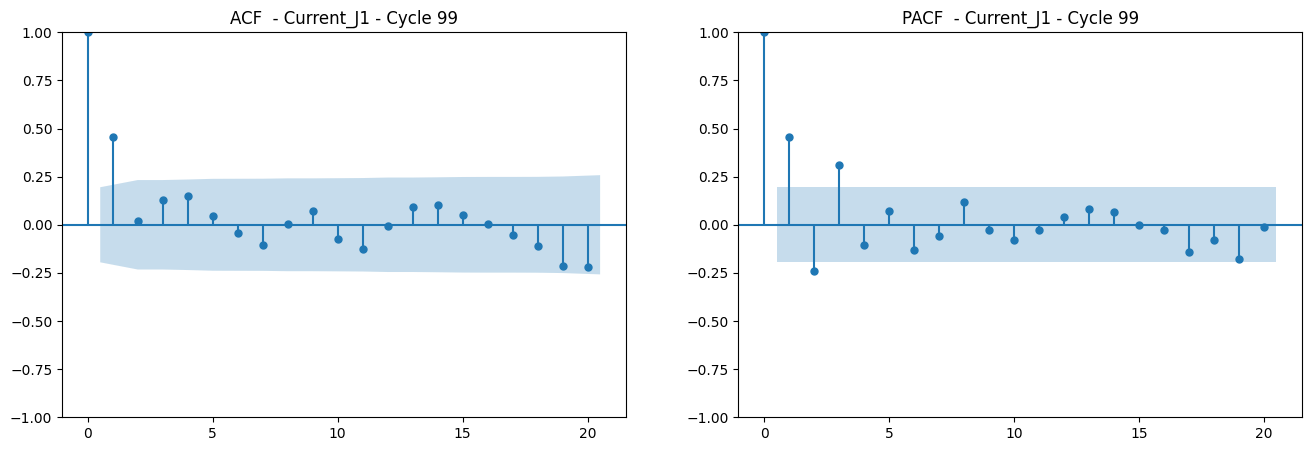

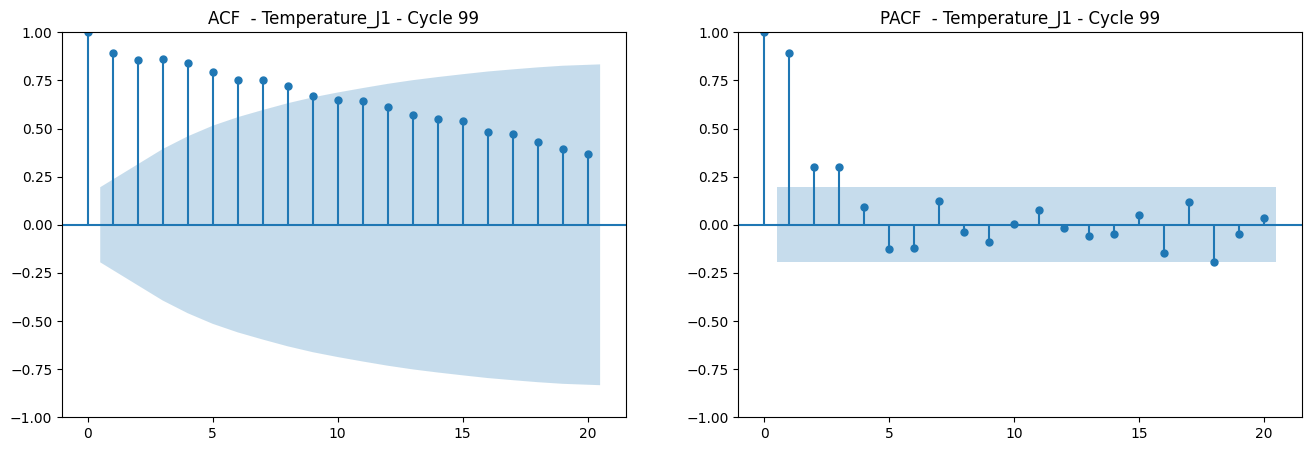

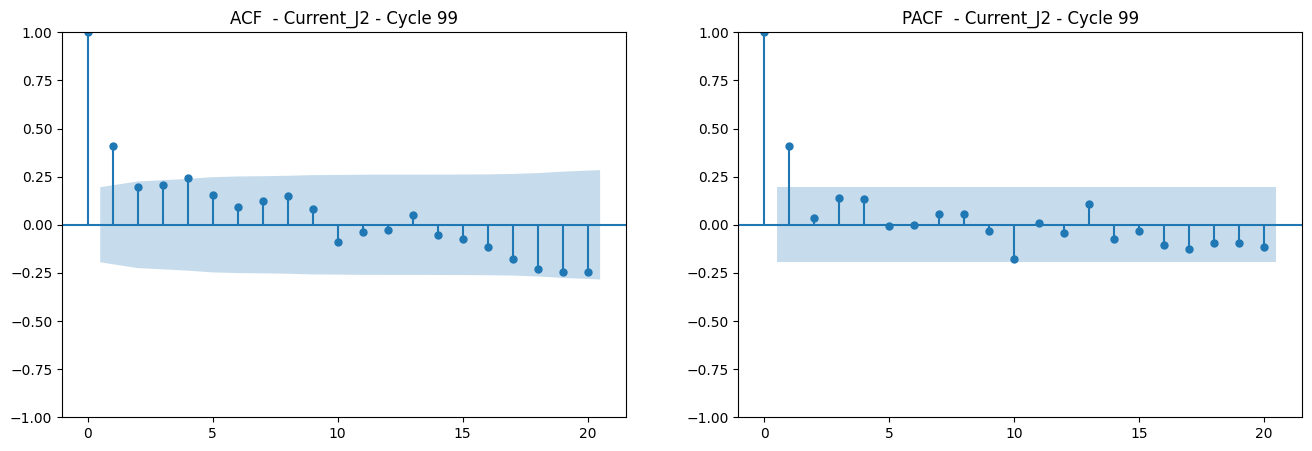

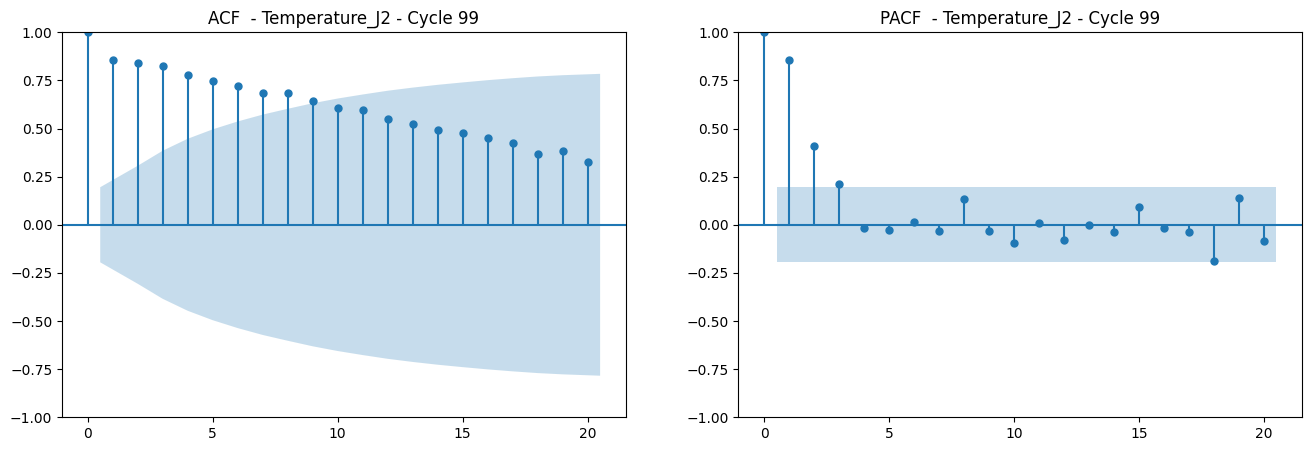

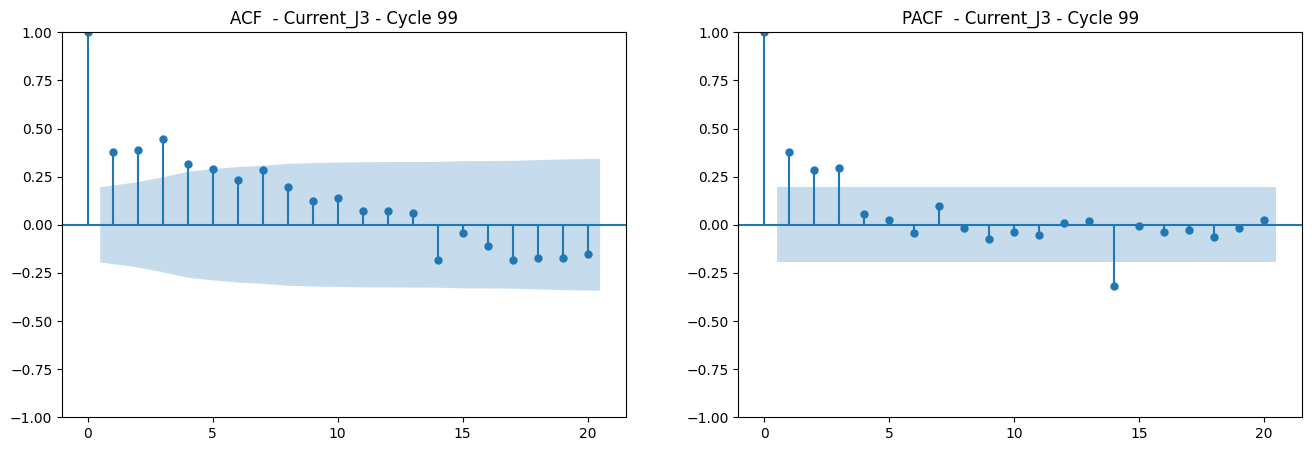

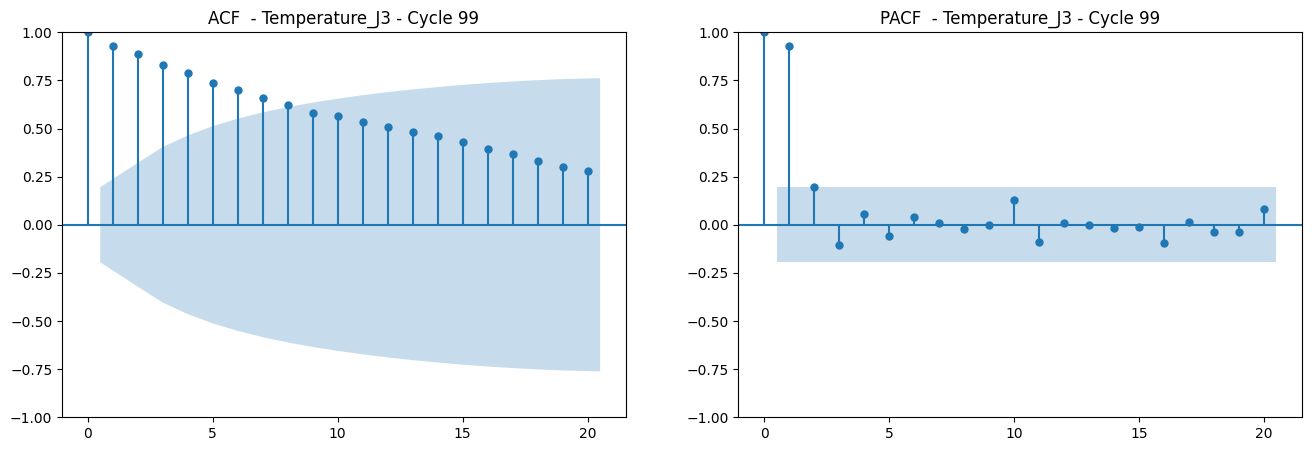

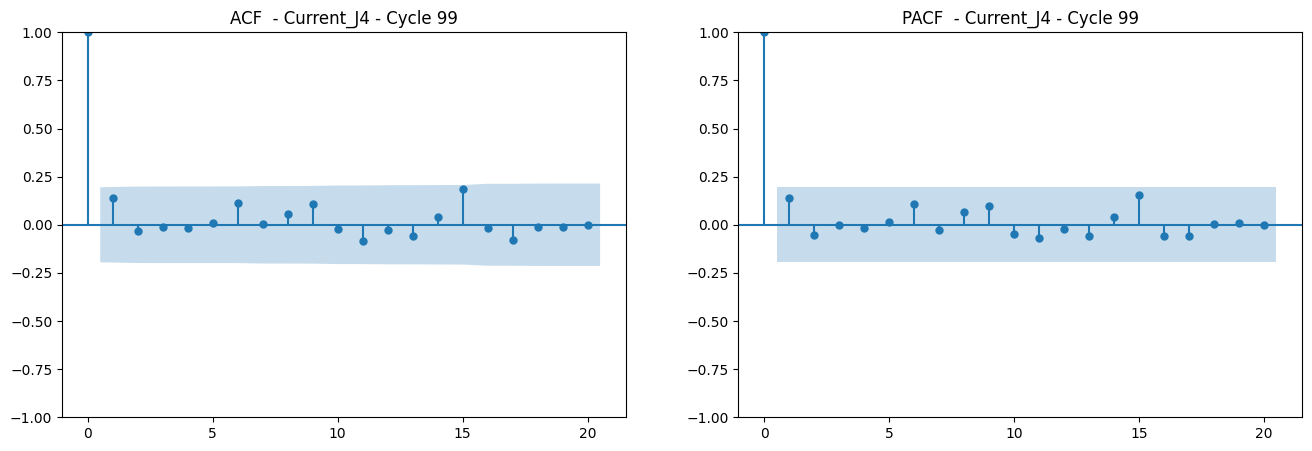

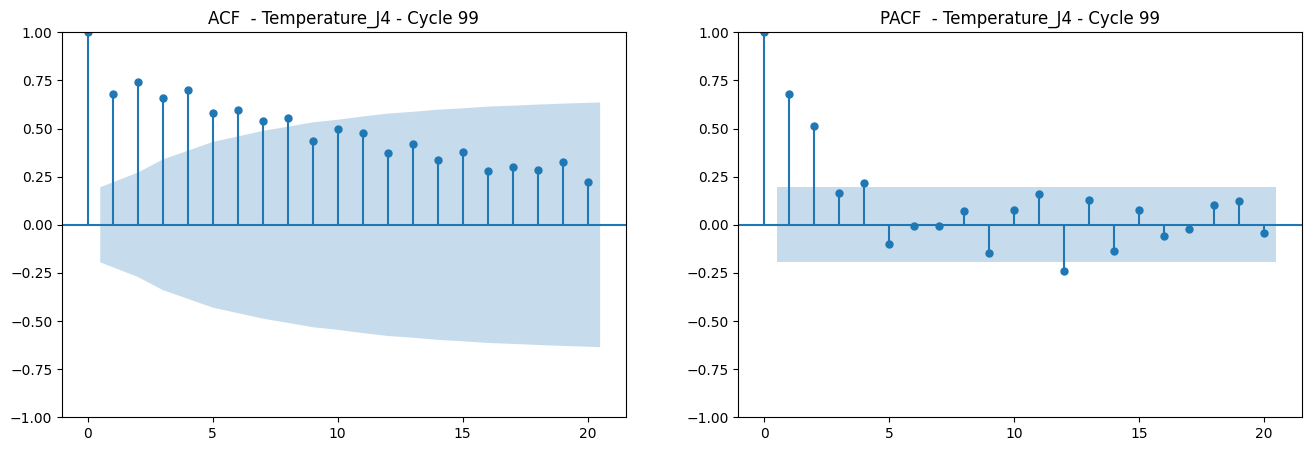

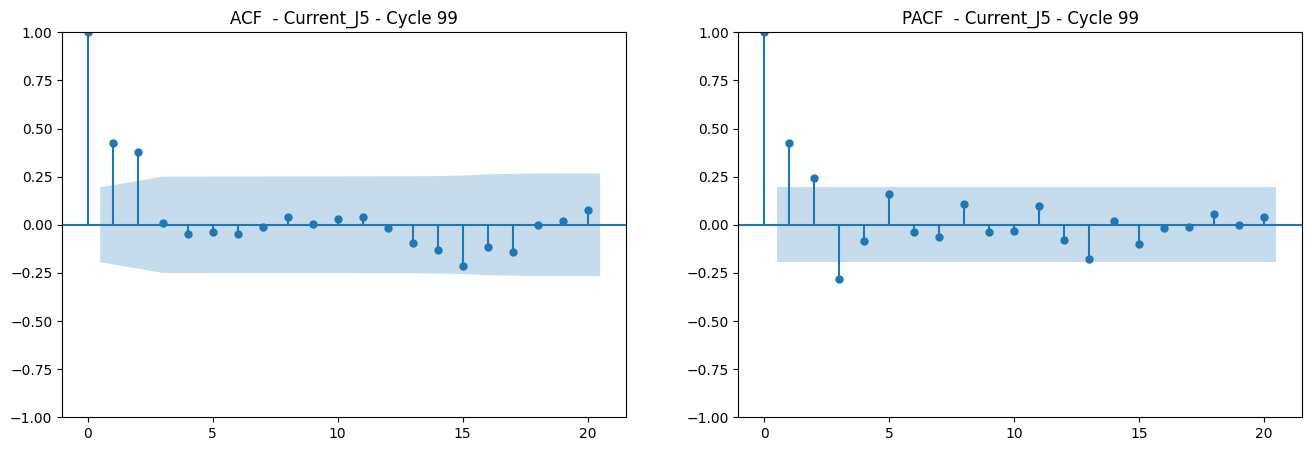

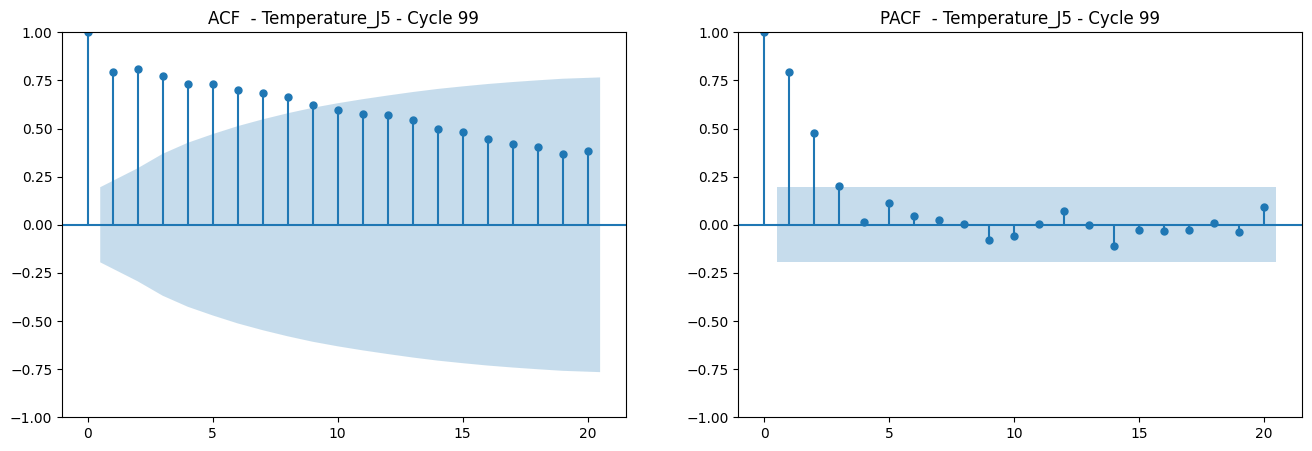

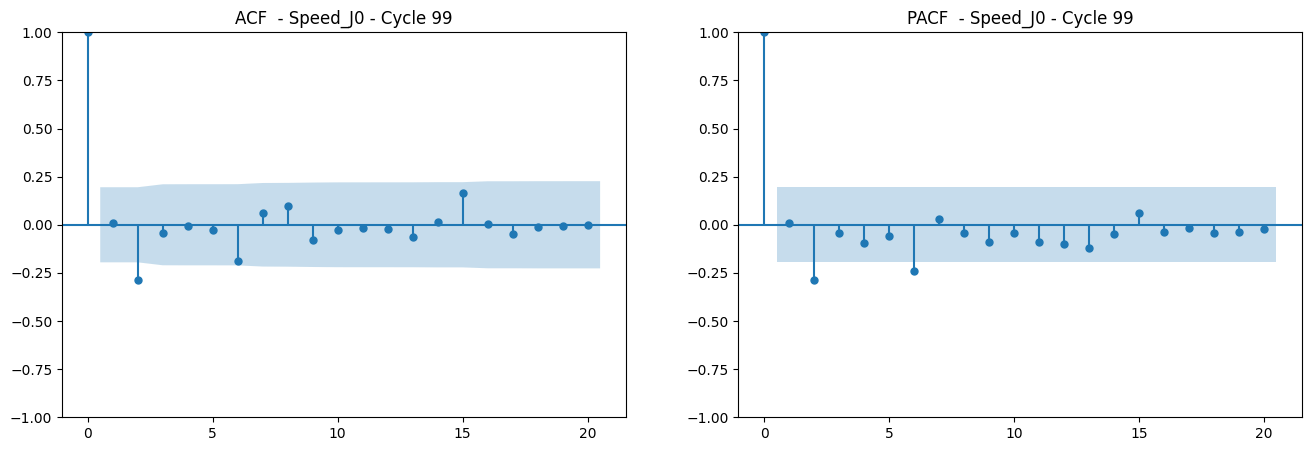

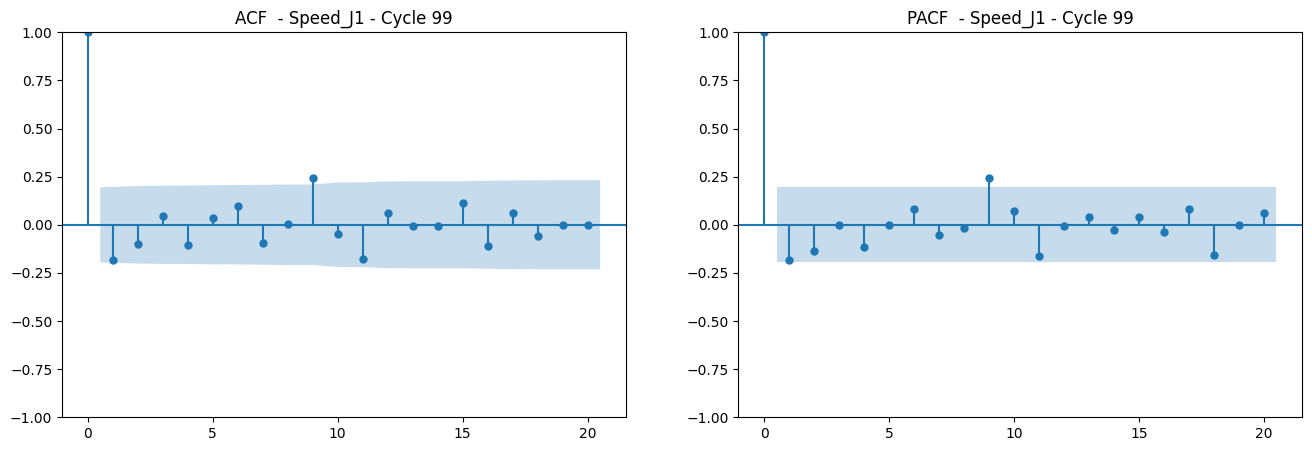

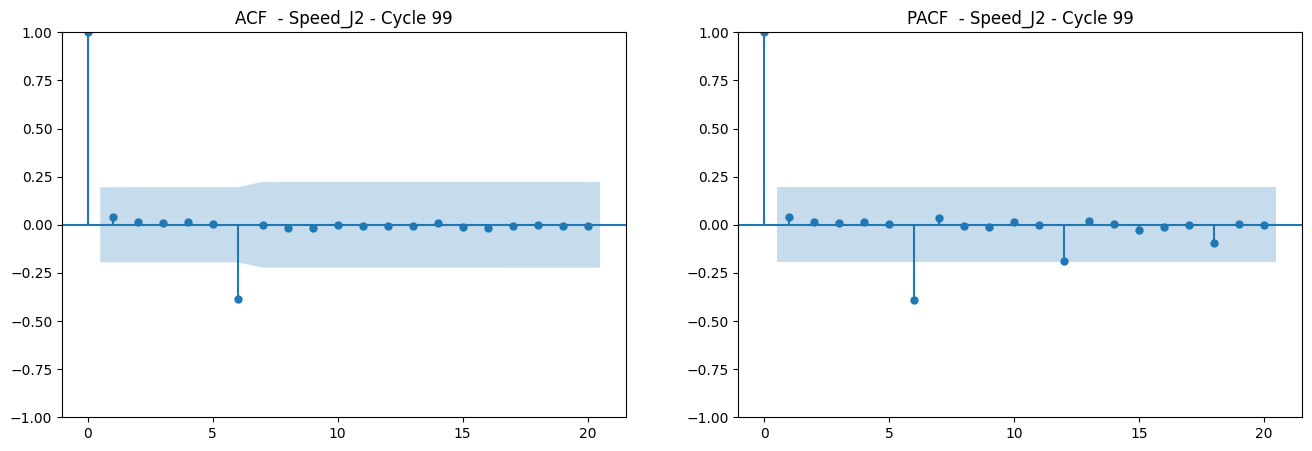

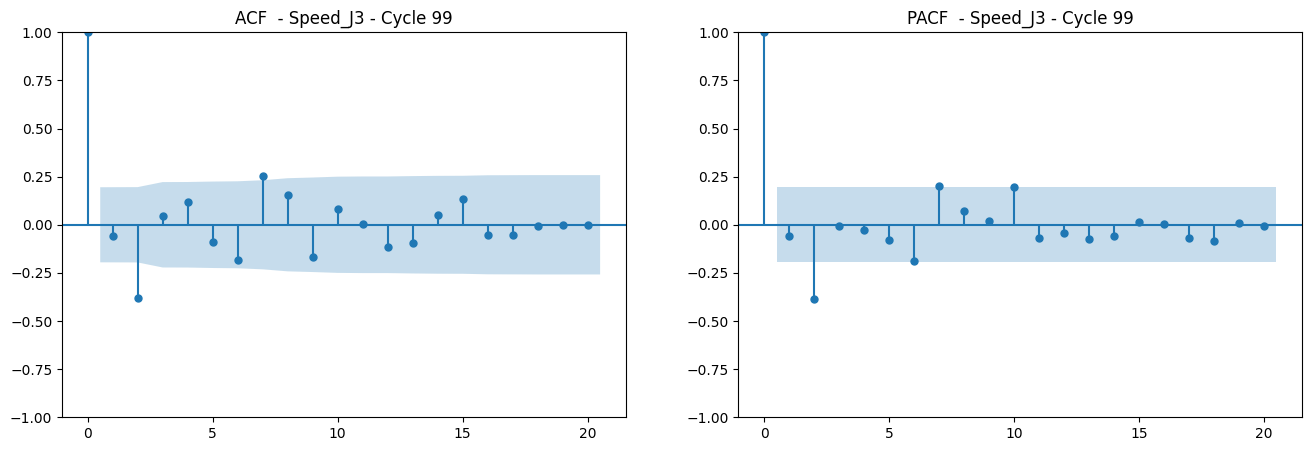

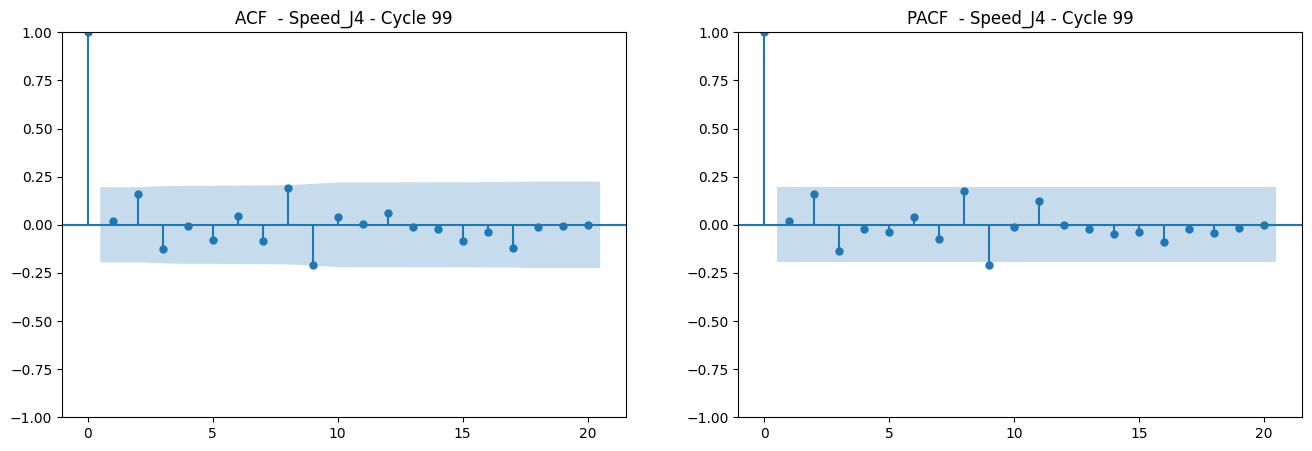

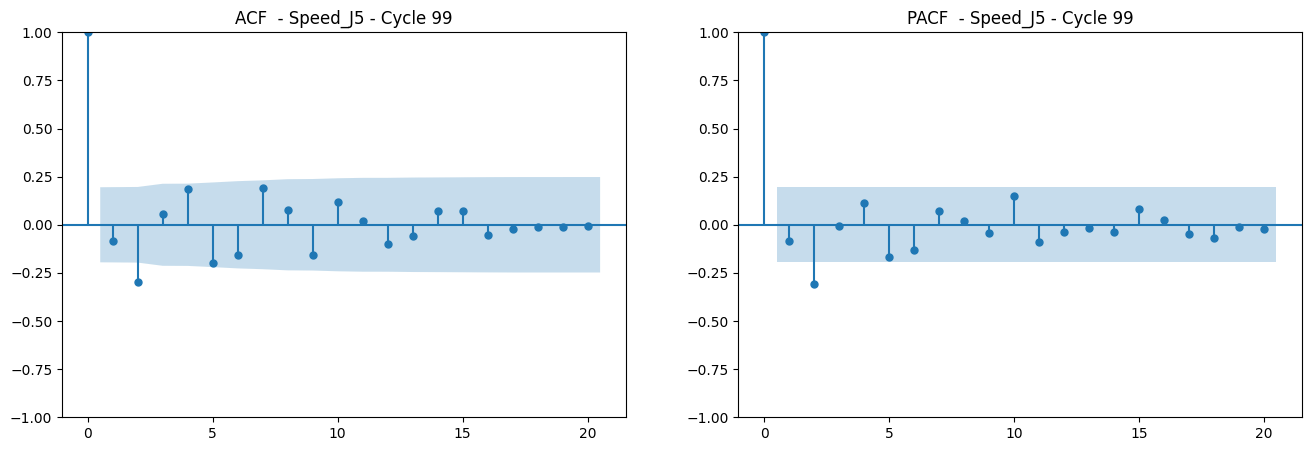

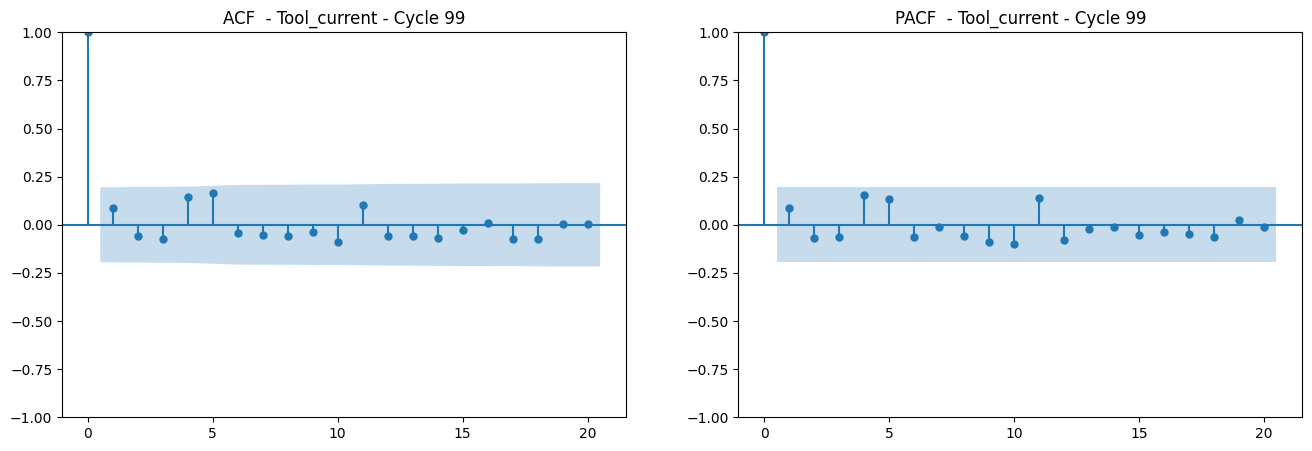

In [48]:
cycle_counts = df_train['cycle'].value_counts()
longest_cycle_id = cycle_counts.idxmax()
longest_cycle_len = cycle_counts.max()

for i, feature_name in enumerate(sensor_cols):
    sensor_demo = sensor_cols[i] 
    series_demo = df_train[df_train['cycle'] == longest_cycle_id][sensor_demo]

    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    plot_acf(series_demo, lags=20, ax=ax[0], title=f'ACF  - {feature_name} - Cycle {longest_cycle_id}')
    plot_pacf(series_demo, lags=20, ax=ax[1], title=f'PACF  - {feature_name} - Cycle {longest_cycle_id}')
    plt.show()


**Justificación de Lags (Ventana Temporal):**

A pesar de que algunos de los sensores no muestran una autocorrelación significativa, sobretodo los de velocidad (esto seguramente se deba a que las muestras se toman cada un segundo y la velocidad puede cambiar rápidamente), la mayoría de sensores físicos presentan cierta dependencia temporal con sus estados anteriores.

Basándonos en el gráfico de **PACF** (Autocorrelación Parcial), que mide la relación directa pura entre instantes, observamos que la "memoria" del sistema se desvanece tras los primeros instantes. Hemos decidido estandarizar el modelo con **5 lags**. Esta ventana es lo suficientemente amplia para cubrir la inercia de los sensores más complejos sin introducir excesivo ruido en los sensores más simples.

In [ ]:

for col in sensor_cols:
    for i in range(1, NUM_LAGS + 1):
        df_prep[f'{col}_lag_{i}'] = df_prep.groupby('cycle')[col].shift(i)

# 5. Eliminación de filas nulas por los lags
df_final = df_prep.dropna().copy()
df_final = df_final[df_final['Status_Combined'] != 3].copy()

print(f"--- PREPROCESAMIENTO COMPLETADO ---")
print(f"Forma final del dataset: {df_final.shape}")
print(f"Distribución de clases (Target):\n{df_final['Status_Combined'].value_counts()}")

In [52]:
df_final.head()

,Current_J0,Temperature_T0,Current_J1,Temperature_J1,Current_J2,Temperature_J2,Current_J3,Temperature_J3,Current_J4,Temperature_J4,...,Speed_J5_lag_1,Speed_J5_lag_2,Speed_J5_lag_3,Speed_J5_lag_4,Speed_J5_lag_5,Tool_current_lag_1,Tool_current_lag_2,Tool_current_lag_3,Tool_current_lag_4,Tool_current_lag_5
5,0.118961,27.8125,-2.162542,29.375,-1.211779,29.4375,-0.481834,32.1875,0.015318,32.3125,...,1.809886e-01,4.255591e-01,-4.968559e-01,0.000417,-0.152962,0.086379,0.083325,0.079420,0.505895,0.082732
6,0.086138,27.8750,-1.757647,29.375,-0.960634,29.4375,-0.488380,32.1875,0.006506,32.3125,...,-2.470161e-03,1.809886e-01,4.255591e-01,-0.496856,0.000417,0.188310,0.086379,0.083325,0.079420,0.505895
7,0.075657,27.8750,-1.836465,29.375,-0.961322,29.4375,-0.512541,32.1875,-0.021845,32.3125,...,1.120000e-44,-2.470161e-03,1.809886e-01,0.425559,-0.496856,0.085192,0.188310,0.086379,0.083325,0.079420
8,-0.186848,27.8750,-2.563738,29.375,-1.418934,29.4375,-0.262015,32.1875,0.099942,32.3125,...,0.000000e+00,1.120000e-44,-2.470161e-03,0.180989,0.425559,0.087058,0.085192,0.188310,0.086379,0.083325
9,-0.158912,27.8750,-1.750777,29.375,-1.979400,29.4375,-0.184550,32.1875,0.079157,32.3125,...,-1.927102e-01,0.000000e+00,1.120000e-44,-0.002470,0.180989,0.085785,0.087058,0.085192,0.188310,0.086379


In [50]:
# Definir X (features) e y (target 0-3)
X = df_final.drop(columns=['Status_Combined', 'cycle']).values
y = df_final['Status_Combined'].values
groups = df_final['cycle'].values

# 5. Split por CICLOS (GroupShuffleSplit)
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
groups_train = groups[train_idx]

# 6. Escalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Analisis de dimensionalidad y Relevancioa con 5-LAG

In [62]:
for col in df_final.columns:
    print(col)

Current_J0
Temperature_T0
Current_J1
Temperature_J1
Current_J2
Temperature_J2
Current_J3
Temperature_J3
Current_J4
Temperature_J4
Current_J5
Temperature_J5
Speed_J0
Speed_J1
Speed_J2
Speed_J3
Speed_J4
Speed_J5
Tool_current
cycle
Status_Combined
Current_J0_lag_1
Current_J0_lag_2
Current_J0_lag_3
Current_J0_lag_4
Current_J0_lag_5
Temperature_T0_lag_1
Temperature_T0_lag_2
Temperature_T0_lag_3
Temperature_T0_lag_4
Temperature_T0_lag_5
Current_J1_lag_1
Current_J1_lag_2
Current_J1_lag_3
Current_J1_lag_4
Current_J1_lag_5
Temperature_J1_lag_1
Temperature_J1_lag_2
Temperature_J1_lag_3
Temperature_J1_lag_4
Temperature_J1_lag_5
Current_J2_lag_1
Current_J2_lag_2
Current_J2_lag_3
Current_J2_lag_4
Current_J2_lag_5
Temperature_J2_lag_1
Temperature_J2_lag_2
Temperature_J2_lag_3
Temperature_J2_lag_4
Temperature_J2_lag_5
Current_J3_lag_1
Current_J3_lag_2
Current_J3_lag_3
Current_J3_lag_4
Current_J3_lag_5
Temperature_J3_lag_1
Temperature_J3_lag_2
Temperature_J3_lag_3
Temperature_J3_lag_4
Temperature_J3_l

In [64]:
for el in df_final["Status_Combined"].unique():
    print(el)

0.0
2.0
1.0


/tmp/ipykernel_2383/3540083503.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.head(20).values, y=correlations.head(20).index, palette='magma')


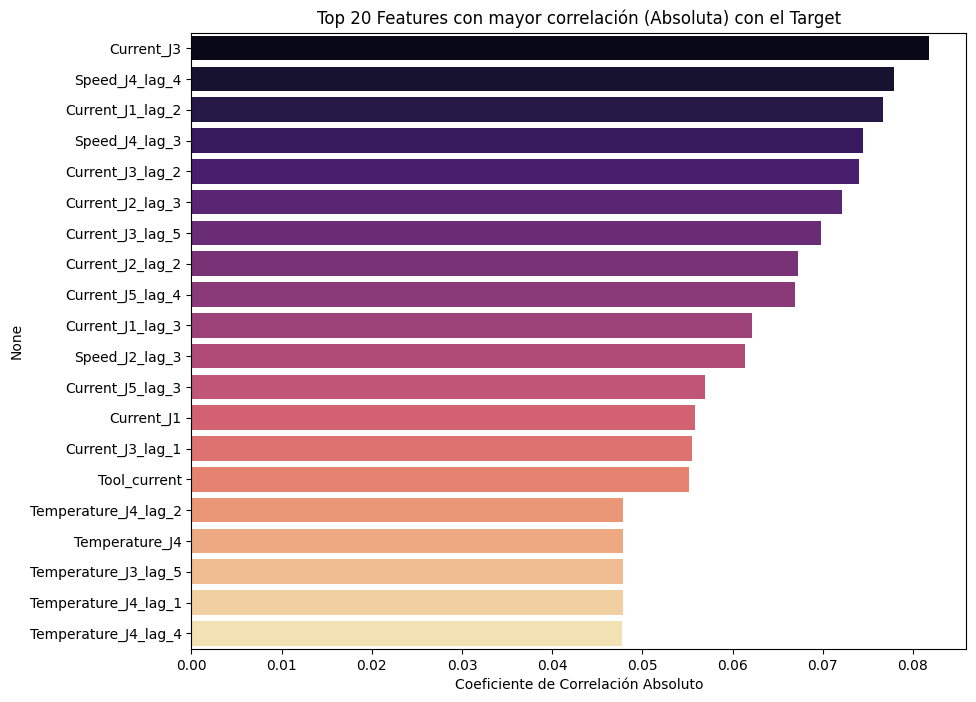

Interpretación: Las barras más largas indican las variables (y sus lags) que más ayudan al modelo a distinguir si hay un fallo o no.

--- RESULTADOS PCA ---
Features originales (con Lags): 114
Componentes necesarios para 95% varianza: 40
Ratio de compresión: 2.9x


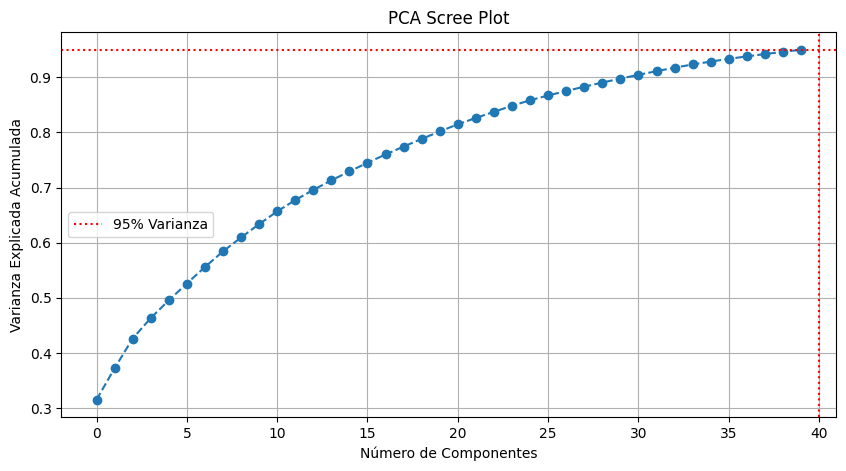

Calculando t-SNE sobre 2000 muestras (usando inputs de PCA)...


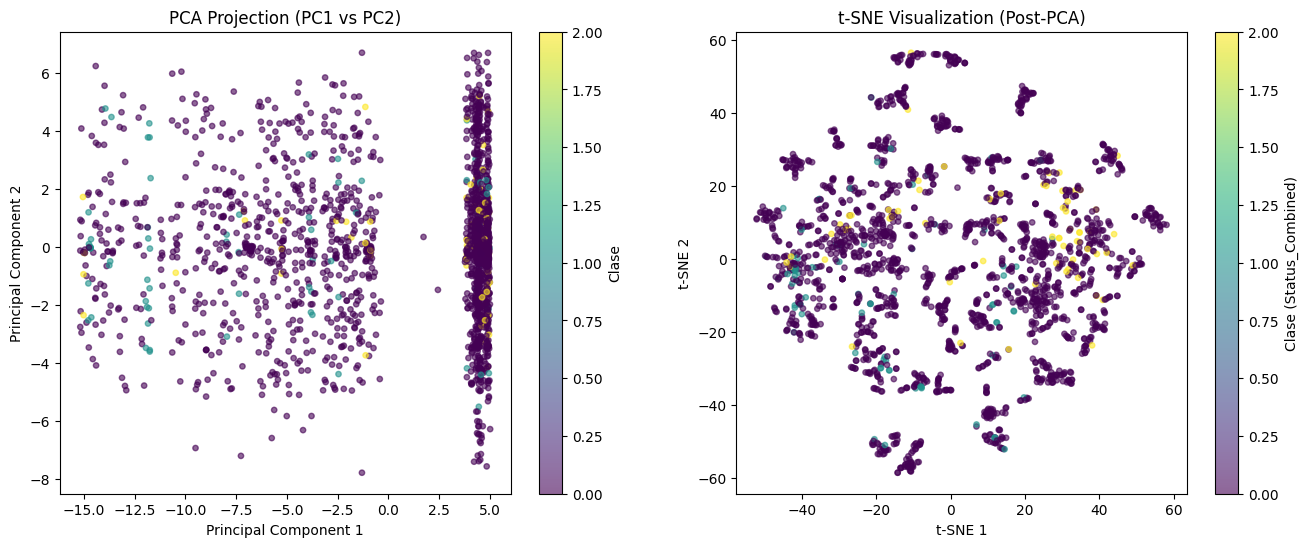

In [ ]:

# 1. CORRELACIÓN CON EL TARGET (Top 20 Features)
# Reconstruimos un DF temporal solo para análisis (X_train ya está escalado)
df_analysis = pd.DataFrame(X_train_scaled, columns=df_final.drop(columns=['Status_Combined', 'cycle']).columns)

# Añadimos el target temporalmente para calcular la correlación
df_analysis['TARGET'] = y_train

# Calculamos la correlación con el TARGET
correlations = df_analysis.corrwith(df_analysis['TARGET']).abs()

# --- CORRECCIÓN IMPORTANTE ---
# Eliminamos la propia columna 'TARGET' de la serie de resultados
# para que no salga con correlación 1.0
correlations = correlations.drop('TARGET', errors='ignore')

# Ordenamos
correlations = correlations.sort_values(ascending=False)

# Visualizamos las 20 más importantes
plt.figure(figsize=(10, 8))
sns.barplot(x=correlations.head(20).values, y=correlations.head(20).index, palette='magma')
plt.title('Top 20 Features con mayor correlación (Absoluta) con el Target')
plt.xlabel('Coeficiente de Correlación Absoluto')
plt.show()

print("Interpretación: Las barras más largas indican las variables (y sus lags) que más ayudan al modelo a distinguir si hay un fallo o no.")

# %%
# 2. PCA: REDUCCIÓN DE DIMENSIONALIDAD
# Queremos ver con cuántos componentes explicamos el 95% de la varianza
pca = PCA(n_components=0.95) 
X_pca = pca.fit_transform(X_train_scaled)

n_components = pca.n_components_
explained_variance = np.sum(pca.explained_variance_ratio_)

print(f"\n--- RESULTADOS PCA ---")
print(f"Features originales (con Lags): {X_train_scaled.shape[1]}")
print(f"Componentes necesarios para 95% varianza: {n_components}")
print(f"Ratio de compresión: {X_train_scaled.shape[1] / n_components:.1f}x")

# Scree Plot (Varianza acumulada)
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle=':', label='95% Varianza')
plt.axvline(x=n_components, color='r', linestyle=':')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('PCA Scree Plot')
plt.legend()
plt.grid(True)
plt.show()

# %%
# 3. VISUALIZACIÓN 2D (t-SNE sobre PCA)
# Usamos un subconjunto para t-SNE porque es muy lento con muchos datos
N_SAMPLES_VIZ = 2000

if X_train_scaled.shape[0] > N_SAMPLES_VIZ:
    # Stratified subsample
    indices = np.arange(X_train_scaled.shape[0])
    _, idx_sub = train_test_split(indices, test_size=N_SAMPLES_VIZ, stratify=y_train, random_state=42)
    # Usamos los datos proyectados por PCA (X_pca) para acelerar t-SNE y quitar ruido
    X_sub_tsne_input = X_pca[idx_sub] 
    y_sub = y_train[idx_sub]
    X_sub_pca = X_pca[idx_sub] # Usamos la proyección PCA correspondiente
else:
    X_sub_tsne_input = X_pca
    y_sub = y_train
    X_sub_pca = X_pca

# T-SNE Plot
print(f"Calculando t-SNE sobre {len(X_sub_tsne_input)} muestras (usando inputs de PCA)...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_sub_tsne_input)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_sub_pca[:, 0], X_sub_pca[:, 1], c=y_sub, cmap='viridis', alpha=0.6, s=15)
plt.title('PCA Projection (PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Clase')

plt.subplot(1, 2, 2)
scatter2 = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sub, cmap='viridis', alpha=0.6, s=15)
plt.title('t-SNE Visualization (Post-PCA)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(scatter2, label='Clase (Status_Combined)')
plt.show()



Separación por ciclos para evitar un tipo de overfitting temporal. El objetivo es predecir si en un nuevo ciclo hay algun fallo, no tiene sentido entrenar al modelo con un ciclo y luego intentar predecir algo de ese mismo ciclo.

### Modelos Lineales

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# 1. Configuración de Grillas de Parámetros
param_grid_log = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}



# 2. Inicialización de GridSearch
# Usamos scoring='f1_macro' para dar importancia equitativa a las clases minoritarias
grid_log = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=5000),
    param_grid_log, 
    cv=StratifiedGroupKFold(n_splits=5), 
    scoring='f1_macro',
    n_jobs=-1
)



# 3. Entrenamiento (usando los datos escalados de tus notebooks)
print("Buscando mejores parámetros para Regresión Logística...")
grid_log.fit(X_train_scaled, y_train, groups=groups_train)


# 4. Comparación y Reporte Final
best_log = grid_log.best_estimator_


best_model = grid_log.best_estimator_
model_name = "Regresión Logística"
params = grid_log.best_params_

print(f"\n--- MEJOR MODELO ENCONTRADO: {model_name} ---")
print(f"Parámetros: {params}")

# Predicción y Reporte con X_test_scaled
y_pred = best_model.predict(X_test_scaled)
print("\nReporte de Clasificación Final:")
print(classification_report(y_test, y_pred))

Buscando mejores parámetros para Regresión Logística...

--- MEJOR MODELO ENCONTRADO: Regresión Logística ---
Parámetros: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

Reporte de Clasificación Final:
              precision    recall  f1-score   support

         0.0       0.98      0.63      0.77      1784
         1.0       0.10      0.80      0.18        44
         2.0       0.11      0.66      0.18        64

    accuracy                           0.63      1892
   macro avg       0.39      0.69      0.38      1892
weighted avg       0.93      0.63      0.73      1892



In [6]:
param_grid_svm = [
    {
        'loss': ['squared_hinge'],
        'penalty': ['l2'],
        'dual': [False, True], 
        'C': [0.1, 1, 10]
    },
    {
        'loss': ['hinge'],
        'penalty': ['l2'],
        'dual': [True],
        'C': [0.1, 1, 10]
    }
]

grid_svm = GridSearchCV(
    LinearSVC(class_weight='balanced', dual=False),
    param_grid_svm, 
    cv=StratifiedGroupKFold(n_splits=5), 
    scoring='f1_macro',
    n_jobs=-1
)

print("Buscando mejores parámetros para Linear SVM...")
grid_svm.fit(X_train_scaled, y_train, groups=groups_train)

best_svm = grid_svm.best_score_

best_model = grid_svm.best_estimator_
model_name = "Linear SVM"
params = grid_svm.best_params_

print(f"\n--- MEJOR MODELO ENCONTRADO: {model_name} ---")
print(f"Parámetros: {params}")

# Predicción y Reporte con X_test_scaled
y_pred = best_model.predict(X_test_scaled)
print("\nReporte de Clasificación Final:")
print(classification_report(y_test, y_pred))

Buscando mejores parámetros para Linear SVM...

--- MEJOR MODELO ENCONTRADO: Linear SVM ---
Parámetros: {'C': 0.1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}

Reporte de Clasificación Final:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      1784
         1.0       0.23      0.27      0.25        44
         2.0       0.22      0.28      0.25        64

    accuracy                           0.90      1892
   macro avg       0.47      0.50      0.48      1892
weighted avg       0.91      0.90      0.91      1892



In [73]:
# %%
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# 1. Configuración de parámetros
# QDA no tiene muchos hiperparámetros, el principal es 'reg_param' que ayuda
# a estabilizar la covarianza si hay pocas muestras o colinealidad.
param_grid_qda = {
    'reg_param': [0.0, 0.01, 0.1, 0.5, 1.0]
}

# 2. Inicialización de GridSearch
# Nota: QDA no tiene 'class_weight', por lo que confía en los 'priors' aprendidos.
# Si el desbalance es muy crítico, este modelo podría sufrir en la clase minoritaria
# comparado con SVM o RF.
grid_qda = GridSearchCV(
    QuadraticDiscriminantAnalysis(),
    param_grid_qda,
    cv=StratifiedGroupKFold(n_splits=5),
    scoring='f1_macro',
    n_jobs=-1
)

# 3. Entrenamiento
print("Entrenando QDA (Análisis Discriminante Cuadrático)...")
grid_qda.fit(X_train_scaled, y_train, groups=groups_train)

# 4. Resultados
best_qda = grid_qda.best_estimator_
print(f"\n--- MEJOR MODELO QDA ---")
print(f"Mejores Parámetros: {grid_qda.best_params_}")

# Predicción
y_pred_qda = best_qda.predict(X_test_scaled)
print("\nReporte de Clasificación (QDA):")
print(classification_report(y_test, y_pred_qda))

Entrenando QDA (Análisis Discriminante Cuadrático)...


Traceback (most recent call last):
  File "/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.13/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L2Rldi9zaG0vam9ibGliX21lbW1hcHBpbmdfZm9sZGVyXzIzODNfMmIyZjAxN2UwMmQzNGUxNjkzZjJkMDhjY2EwOTFiNTlfODg2MTAxZDgyNDI2NGM5N2FkODg0YTUwMjEyNjhjYjQ="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.13/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"semlock","base64_name" for automatic cleanup: unknown resource type ("L2xva3ktMjM4My11NmhuXzBucw=="}). Resource type should be one of 


--- MEJOR MODELO QDA ---
Mejores Parámetros: {'reg_param': 0.01}

Reporte de Clasificación (QDA):
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81      1784
         1.0       0.09      0.80      0.15        44
         2.0       0.17      0.55      0.26        64

    accuracy                           0.69      1892
   macro avg       0.41      0.68      0.41      1892
weighted avg       0.92      0.69      0.78      1892



### Modelos No Lineares

In [4]:
min_samples = pd.Series(y_train).value_counts().min()
# Si la clase más pequeña tiene 2 muestras, solo podemos usar 1 vecino.
k_neighbors_adj = min(5, min_samples - 1) 

print(f"\nAplicando SMOTE con k_neighbors={k_neighbors_adj} (Clase minoritaria tiene {min_samples} muestras)")

handler = ImbalanceHandler()
# Pasamos el parámetro k_neighbors para que no use el valor por defecto de 5
X_train_res, y_train_res = handler.smote_data(X_train_scaled, y_train, k_neighbors=k_neighbors_adj)

# Convertir a Tensores de PyTorch
X_train_t = torch.tensor(X_train_res, dtype=torch.float32)
y_train_t = torch.tensor(y_train_res, dtype=torch.long) # Long para clasificación multiclase
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

# ==========================================
# 4. MODELO DE RED NEURONAL Y ENTRENAMIENTO
# ==========================================

class RobotClassifier(nn.Module):
    def __init__(self, input_dim):
        super(RobotClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3) # Salida: 4 neuronas (clases 0, 1, 2)
        )
        
    def forward(self, x):
        return self.model(x)

model = RobotClassifier(X_train_t.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
print("\nEntrenando...")
model.train()
for epoch in range(50):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

# Evaluación final
model.eval()
with torch.no_grad():
    logits = model(X_test_t)
    preds = torch.argmax(logits, dim=1)

print("\nReporte Final de Clasificación:")
print(classification_report(y_test, preds.numpy()))


Aplicando SMOTE con k_neighbors=5 (Clase minoritaria tiene 140 muestras)

Entrenando...

Reporte Final de Clasificación:
              precision    recall  f1-score   support

         0.0       0.98      0.59      0.74      1784
         1.0       0.08      0.80      0.15        44
         2.0       0.11      0.69      0.20        64

    accuracy                           0.60      1892
   macro avg       0.39      0.69      0.36      1892
weighted avg       0.93      0.60      0.71      1892



In [7]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

# 1. Configuración de la Grilla de Parámetros
param_grid_rf = {
    'n_estimators': [3, 5, 10, 30, 100, 200, 300],
    'max_depth': [1, 3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample']
}


# 3. Inicialización del GridSearch
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=StratifiedGroupKFold(n_splits=5),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# 4. Entrenamiento
print("Buscando mejores parámetros para Random Forest...")
grid_rf.fit(X_train_scaled, y_train, groups=groups_train)

# 5. Reporte de Resultados
best_rf = grid_rf.best_estimator_
print(f"\n--- MEJOR MODELO ENCONTRADO: Random Forest ---")
print(f"Mejores Parámetros: {grid_rf.best_params_}")

# Predicción y Evaluación
y_pred_rf = best_rf.predict(X_test_scaled)
print("\nReporte de Clasificación Final (Test Set):")
print(classification_report(y_test, y_pred_rf))

Buscando mejores parámetros para Random Forest...
Fitting 5 folds for each of 252 candidates, totalling 1260 fits

--- MEJOR MODELO ENCONTRADO: Random Forest ---
Mejores Parámetros: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 30}

Reporte de Clasificación Final (Test Set):
              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93      1784
         1.0       0.20      0.50      0.29        44
         2.0       0.29      0.70      0.41        64

    accuracy                           0.87      1892
   macro avg       0.49      0.70      0.54      1892
weighted avg       0.93      0.87      0.90      1892



In [74]:
# %%
from sklearn.svm import SVC

# 1. Configuración de la Grilla
param_grid_rbf = {
    'C': [0.1, 1, 10, 100],           # Penalización de error
    'gamma': ['scale', 'auto', 0.1],  # Coeficiente del kernel (cuánto influye cada punto)
    'class_weight': ['balanced']      # Crucial para tu desbalance
}

# 2. Inicialización
grid_rbf = GridSearchCV(
    SVC(kernel='rbf', cache_size=1000), # cache_size acelera el entrenamiento
    param_grid_rbf,
    cv=StratifiedGroupKFold(n_splits=5),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# 3. Entrenamiento
print("Entrenando SVM con Kernel RBF (Esto puede tardar)...")
# Usamos X_train_scaled (datos originales escalados) con class_weight='balanced'
# en lugar de los datos SMOTE, ya que SVM maneja muy bien los pesos internos.
grid_rbf.fit(X_train_scaled, y_train, groups=groups_train)

# 4. Resultados
best_rbf = grid_rbf.best_estimator_
print(f"\n--- MEJOR MODELO SVM-RBF ---")
print(f"Mejores Parámetros: {grid_rbf.best_params_}")

# Predicción
y_pred_rbf = best_rbf.predict(X_test_scaled)
print("\nReporte de Clasificación (SVM-RBF):")
print(classification_report(y_test, y_pred_rbf))

Entrenando SVM con Kernel RBF (Esto puede tardar)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Traceback (most recent call last):
  File "/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.13/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L2Rldi9zaG0vam9ibGliX21lbW1hcHBpbmdfZm9sZGVyXzIzODNfYzQzMDg2MjIzZWMzNDlkOWFiZGYwYzJhZjA3MTk1M2VfYmIzZGEzM2ViNjMxNGQxMGJjZjAzNDY4NjE0YzFlYTI="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.13/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L2Rldi9zaG0vam9ibGliX21lbW1hcHBpbmdfZm9sZGVyXzIzODNfMmIyZjAxN2UwM


--- MEJOR MODELO SVM-RBF ---
Mejores Parámetros: {'C': 100, 'class_weight': 'balanced', 'gamma': 'auto'}

Reporte de Clasificación (SVM-RBF):
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96      1784
         1.0       0.28      0.59      0.38        44
         2.0       0.49      0.30      0.37        64

    accuracy                           0.92      1892
   macro avg       0.58      0.61      0.57      1892
weighted avg       0.93      0.92      0.92      1892

